In [1]:
import pandas as pd
import numpy as np
import re

# set display option to show all columns
pd.set_option('display.max_columns', None)

# load the dataset
df = pd.read_csv("traffic.csv", header=None)

# assign column names
column_names = [
    "Juhtumi nr", "Toimumisaeg", "Isikuid", "Hukkunuid", "Vigastatuid", 
    "Sõidukeid", "Aadress (PPA)", "Maja nr (PPA)", "Tänav (PPA)", 
    "Ristuv tänav (PPA)", "Maakond (PPA)", "Omavalitsus (PPA)", 
    "Asustus (PPA)", "Asula", "Liiklusõnnetuse liik [1]", 
    "Liiklusõnnetuse liik [3]", "Kergliikurijuhi osalusel", 
    "Jalakäija osalusel", "Kaassõitja osalusel", "Maastikusõiduki juhi osalusel",
    "Eaka (65+) mootorsõidukijuhi osalusel", "Bussijuhi osalusel", 
    "Veoautojuhi osalusel", "Ühissõidukijuhi osalusel", "Sõiduautojuhi osalusel",
    "Mootorratturi osalusel", "Mopeedijuhi osalusel", "Jalgratturi osalusel", 
    "Alaealise osalusel", "Turvavarustust mitte kasutanud isiku osalusel", 
    "Esmase juhiloa omaniku osalusel", "Mootorsõidukijuhi osalusel", 
    "Tüüpskeemi nr", "Tüüpskeem [2]", "Tee tüüp [1]", "Tee tüüp [2]", 
    "Tee element [1]", "Tee element [2]", "Tee objekt [2]", 
    "Kurvilisus", "Tee tasasus", "Tee seisund", "Teekate", 
    "Teekatte seisund [2]", "Sõiduradade arv", "Lubatud sõidukiirus (PPA)", 
    "Tee nr (PPA)", "Tee km (PPA)", "Ilmastik [1]", "Valgustus [1]", 
    "Valgustus [2]", "GPS X", "GPS Y"
]

df.columns = column_names

# function to check if time component is present
def time_present(date_str):
    if isinstance(date_str, str) and re.search(r'\d{1,2}[:]\d{2}', date_str):
        return True
    else:
        return False

# apply the function to check for time presence
df['Time_Present'] = df['Toimumisaeg'].apply(time_present)

# parse the 'Toimumisaeg' column
df['Parsed_Date'] = pd.to_datetime(df['Toimumisaeg'], dayfirst=True, errors='coerce')

# extract date features
df['Year'] = df['Parsed_Date'].dt.year
df['Month'] = df['Parsed_Date'].dt.month
df['DayOfWeek'] = df['Parsed_Date'].dt.dayofweek  # 0 = monday

# set 'Hour' to -1 if time is missing
df['Hour'] = df['Parsed_Date'].dt.hour
df.loc[~df['Time_Present'], 'Hour'] = -1

# handle missing time-based features
time_columns = ['Year', 'Month', 'DayOfWeek', 'Hour']
df[time_columns] = df[time_columns].fillna(-1).astype(int)

# clean numerical columns
numerical_columns = ['Isikuid', 'Hukkunuid', 'Vigastatuid', 'Sõidukeid', 'Sõiduradade arv']
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# create binary columns for fatalities and injuries
df['Fatal_Accident'] = (df['Hukkunuid'] > 0).astype(int)
df['Injury_Accident'] = (df['Vigastatuid'] > 0).astype(int)

# standardize categorical variables (strip whitespace and convert to lowercase)
categorical_columns = [
    'Maakond (PPA)', 'Ilmastik [1]', 'Tee tüüp [1]', 
    'Valgustus [1]', 'Tee seisund', 'Teekatte seisund [2]'
]
for col in categorical_columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

# display the first few rows to verify
df.head()


,Juhtumi nr,Toimumisaeg,Isikuid,Hukkunuid,Vigastatuid,Sõidukeid,Aadress (PPA),Maja nr (PPA),Tänav (PPA),Ristuv tänav (PPA),Maakond (PPA),Omavalitsus (PPA),Asustus (PPA),Asula,Liiklusõnnetuse liik [1],Liiklusõnnetuse liik [3],Kergliikurijuhi osalusel,Jalakäija osalusel,Kaassõitja osalusel,Maastikusõiduki juhi osalusel,Eaka (65+) mootorsõidukijuhi osalusel,Bussijuhi osalusel,Veoautojuhi osalusel,Ühissõidukijuhi osalusel,Sõiduautojuhi osalusel,Mootorratturi osalusel,Mopeedijuhi osalusel,Jalgratturi osalusel,Alaealise osalusel,Turvavarustust mitte kasutanud isiku osalusel,Esmase juhiloa omaniku osalusel,Mootorsõidukijuhi osalusel,Tüüpskeemi nr,Tüüpskeem [2],Tee tüüp [1],Tee tüüp [2],Tee element [1],Tee element [2],Tee objekt [2],Kurvilisus,Tee tasasus,Tee seisund,Teekate,Teekatte seisund [2],Sõiduradade arv,Lubatud sõidukiirus (PPA),Tee nr (PPA),Tee km (PPA),Ilmastik [1],Valgustus [1],Valgustus [2],GPS X,GPS Y,Time_Present,Parsed_Date,Year,Month,DayOfWeek,Hour,Fatal_Accident,Injury_Accident
0,2300150007185,20.11.2015 05:31,2,1,0,1,Harju maakond Tallinn Lasnamäe linnaosa Peter...,NaN,Peterburi tee,Pae tn,harju maakond,Tallinn,Lasnamäe linnaosa,JAH,Jalakäijaõnnetus,Kokkupõrge jalakäijaga,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,103,Sõiduki konflikt teelõiku vasakult poolt ületa...,kov tee/tänav,Tänav,NaN,NaN,Fooriga reguleeritud ristmik,NaN,Tasane tee,sõidutee on korras,Püsikate,märg,0,50,NaN,NaN,vihmasadu,pimeda aeg,Pimeda ajal valgustus põleb,6587834,545426,True,2015-11-20 05:31:00,2015,11,4,5,1,0
1,2300150007535,9/12/15,3,1,0,2,Harju maakond Tallinn Põhja-Tallinna linnaosa...,60,Sõle tn,NaN,harju maakond,Tallinn,Põhja-Tallinna linnaosa,JAH,Jalakäijaõnnetus,Kokkupõrge jalakäijaga,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,198,Muu konflikt sõiduki ja jalakäija vahel (nt. k...,kov tee/tänav,Tänav,Ristmik,†-kujuline ristmik,Fooriga reguleeritud ristmik,Sirge tee,Tasane tee,sõidutee on korras,Püsikate,märg,0,50,NaN,NaN,pilvised olud,valge aeg,Valge aeg,6590467,539630,False,NaT,-1,-1,-1,-1,1,0
2,2300160007343,26.12.2016 00:30,1,1,0,1,Harju maakond Saku vald,NaN,TALLINN - SAKU - LAAGRI,NaN,harju maakond,Saku vald,NaN,EI,Ühesõidukiõnnetus,Sõiduki teelt väljasõit,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,203,Sõiduk kaotab teelõigul või ristmikul juhitavu...,riigitee,Kõrvalmaantee,Erielemendita teelõik,Erielemendita teelõik,Rajatis puudub,Sirge tee,Tasane tee,sõidutee on korras,Püsikate,kuiv,2,90,11340,8,pilvised olud,pimeda aeg,Pimeda ajal valgustus puudub,6576196,539214,True,2016-12-26 00:30:00,2016,12,0,0,1,0
3,2300200000698,27.01.2020 20:04,2,1,0,1,Harju maakond Tallinn Lasnamäe linnaosa Narva...,NaN,Narva mnt,J. Smuuli tee,harju maakond,Tallinn,Lasnamäe linnaosa,JAH,Jalakäijaõnnetus,Kokkupõrge jalakäijaga,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,108,Otse sõitva ja ristmikult lahkuva sõiduki konf...,kov tee/tänav,Tänav,Ristmik,†-kujuline ristmik,Fooriga reguleeritud ristmik,Sirge tee,Tasane tee,sõidutee on korras,Püsikate,märg,0,50,NaN,NaN,vihmasadu,pimeda aeg,Pimeda ajal valgustus põleb,6590122,546479,True,2020-01-27 20:04:00,2020,1,0,20,1,0
4,2300200008312,20.06.2020 19:09,2,1,0,2,Harju maakond Tallinn Pirita linnaosa Randver...,NaN,Randvere tee,Pojengi tee,harju maakond,Tallinn,Pirita linnaosa,JAH,Kokkupõrge,Kokkupõrge sõidukiga küljelt,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,501,Ristmiku peateel otse sõitva sõiduki konflikt ...,kov tee/tänav,Tänav,Ristmik,†-kujuline ristmik,Reguleerimata ristmik – liiklusmärkideta,Sirge tee,Tasane tee,sõidutee on korras,Püsikate,kuiv,0,50,NaN,NaN,selged olud,valge aeg,Valge aeg,6594972,549609,True,2020-06-20 19:09:00,2020,6,5,19,1,0


# Task 2: Identifying High-Risk Locations and Conditions
In this section, we'll analyze the dataset to identify locations and conditions that are associated with higher accident counts and fatality rates.

#### Task 2a: High-Risk Locations
We'll identify the locations with the highest number of accidents and fatalities.

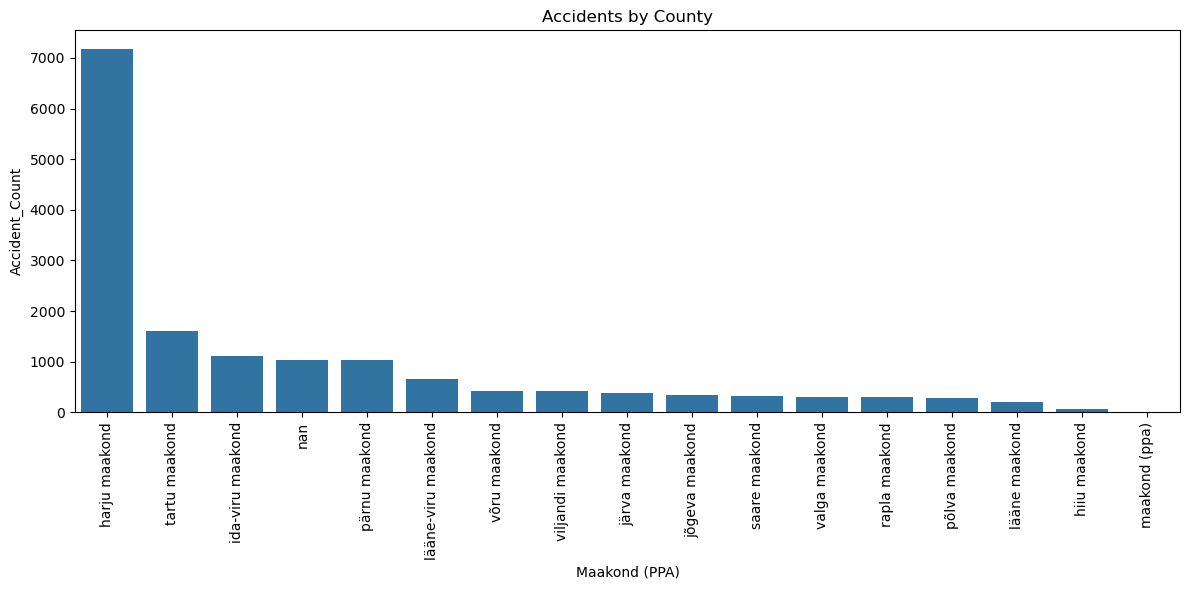

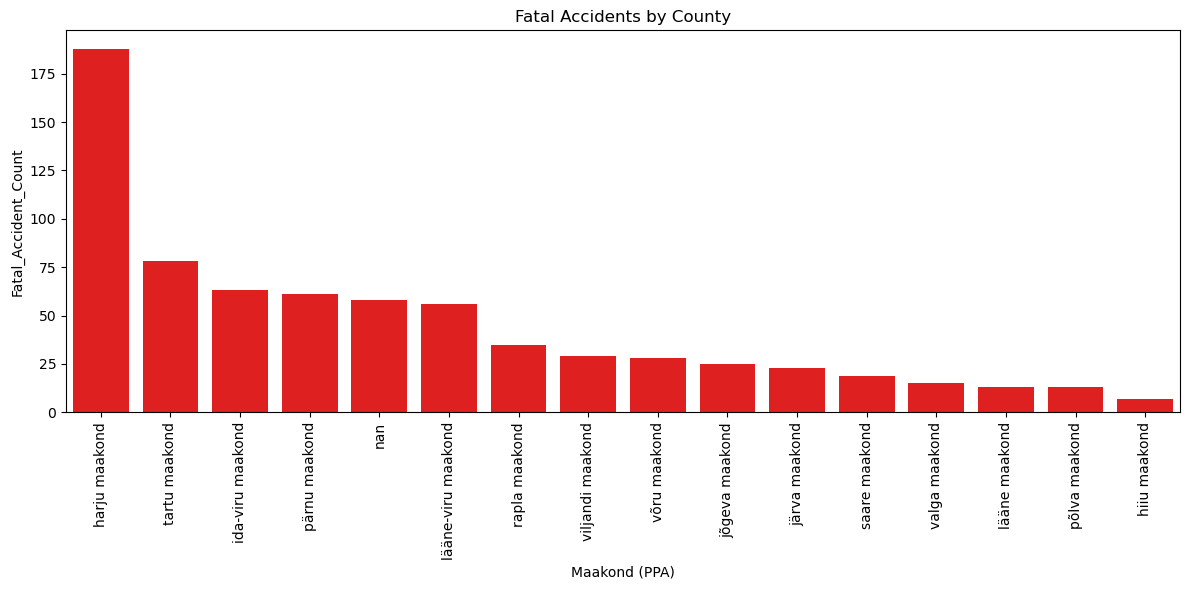

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# filter out entries with missing 'Maakond (PPA)'
df_valid_locations = df[df['Maakond (PPA)'].notna()]

# accidents by county
accidents_by_county = df_valid_locations['Maakond (PPA)'].value_counts().reset_index()
accidents_by_county.columns = ['Maakond (PPA)', 'Accident_Count']

# plot accidents by county
plt.figure(figsize=(12, 6))
sns.barplot(data=accidents_by_county, x='Maakond (PPA)', y='Accident_Count')
plt.title('Accidents by County')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# fatal accidents by county
fatal_accidents_by_county = df_valid_locations[df_valid_locations['Fatal_Accident'] == 1]['Maakond (PPA)'].value_counts().reset_index()
fatal_accidents_by_county.columns = ['Maakond (PPA)', 'Fatal_Accident_Count']

# plot fatal accidents by county
plt.figure(figsize=(12, 6))
sns.barplot(data=fatal_accidents_by_county, x='Maakond (PPA)', y='Fatal_Accident_Count', color='red')
plt.title('Fatal Accidents by County')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Task 2b: High-Risk Conditions
#### We'll analyze environmental and road conditions to see which are most associated with accidents and fatalities.

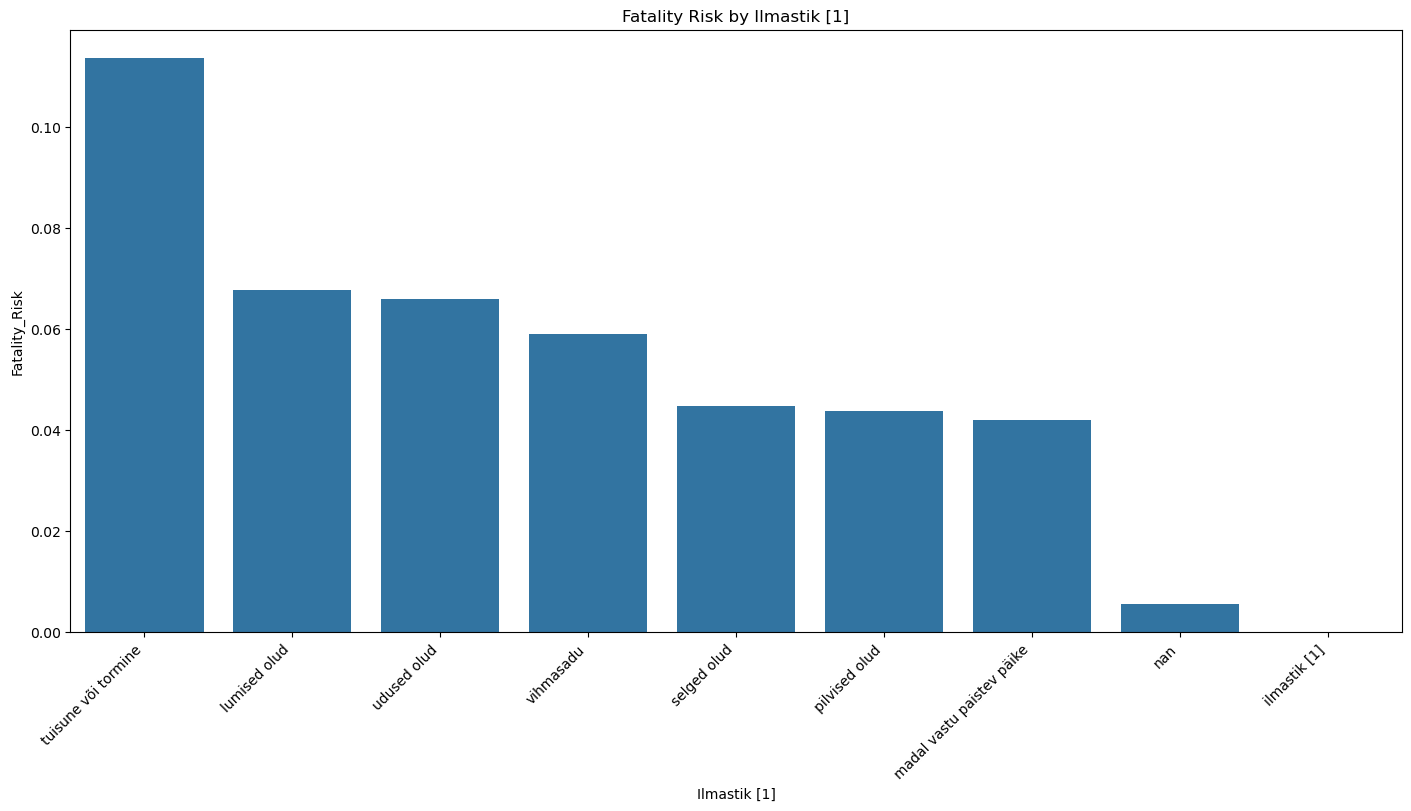

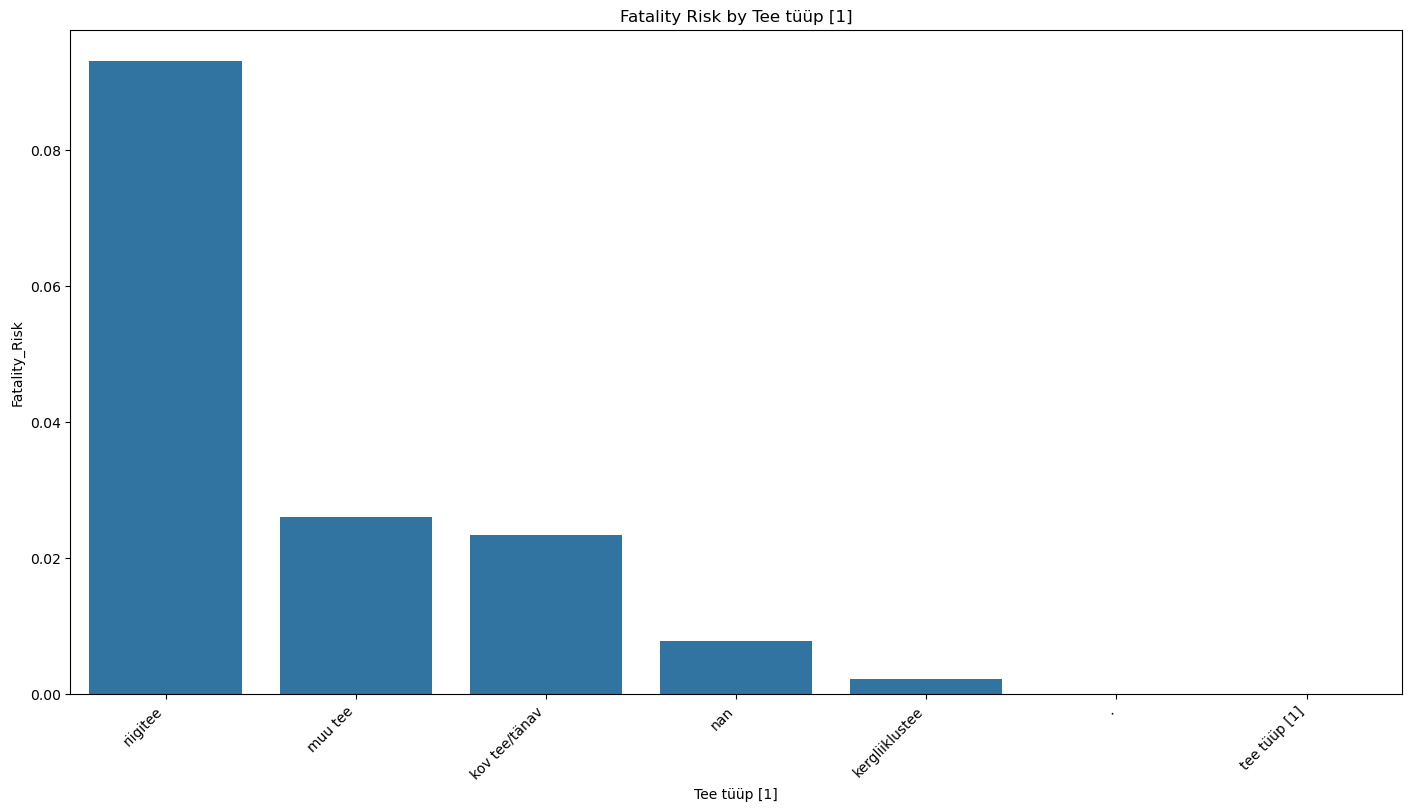

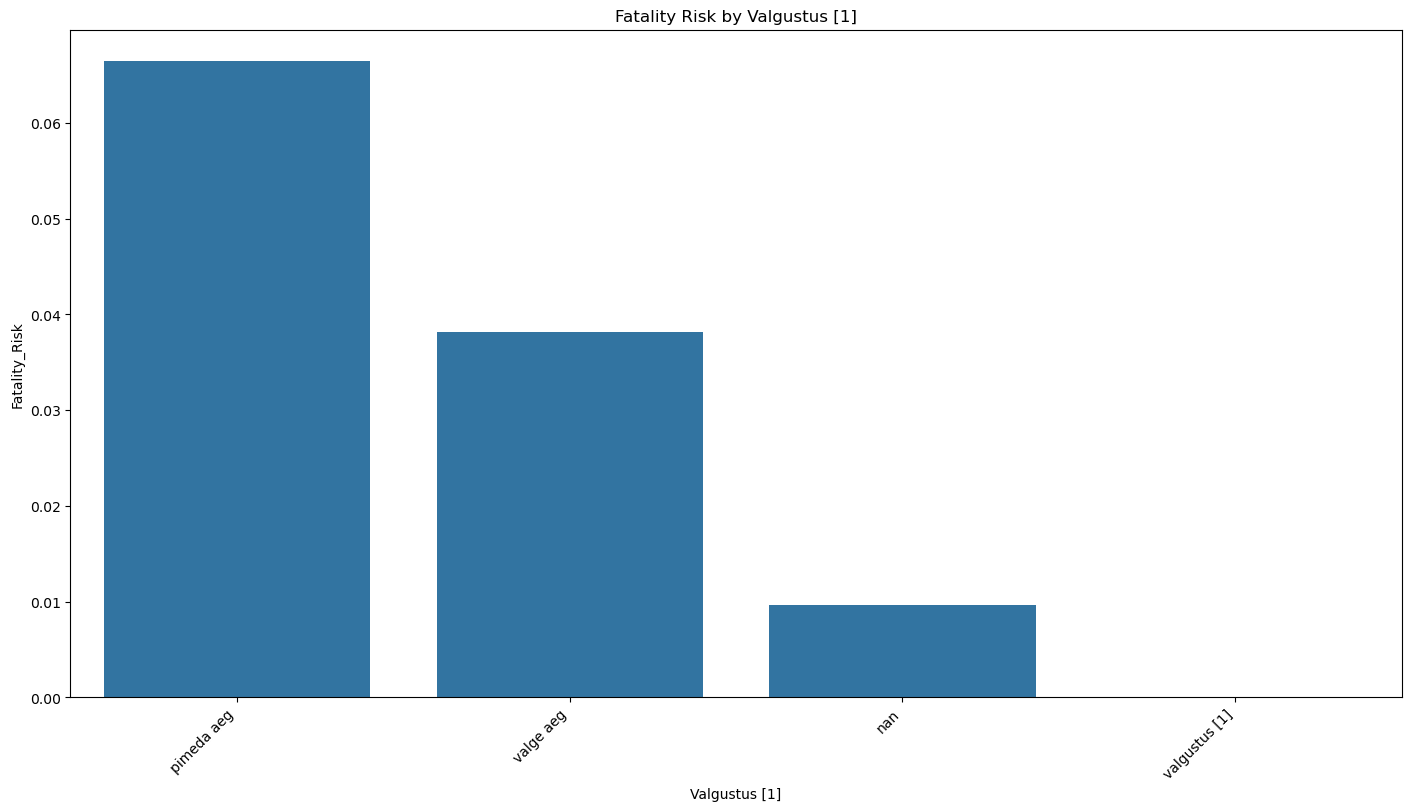

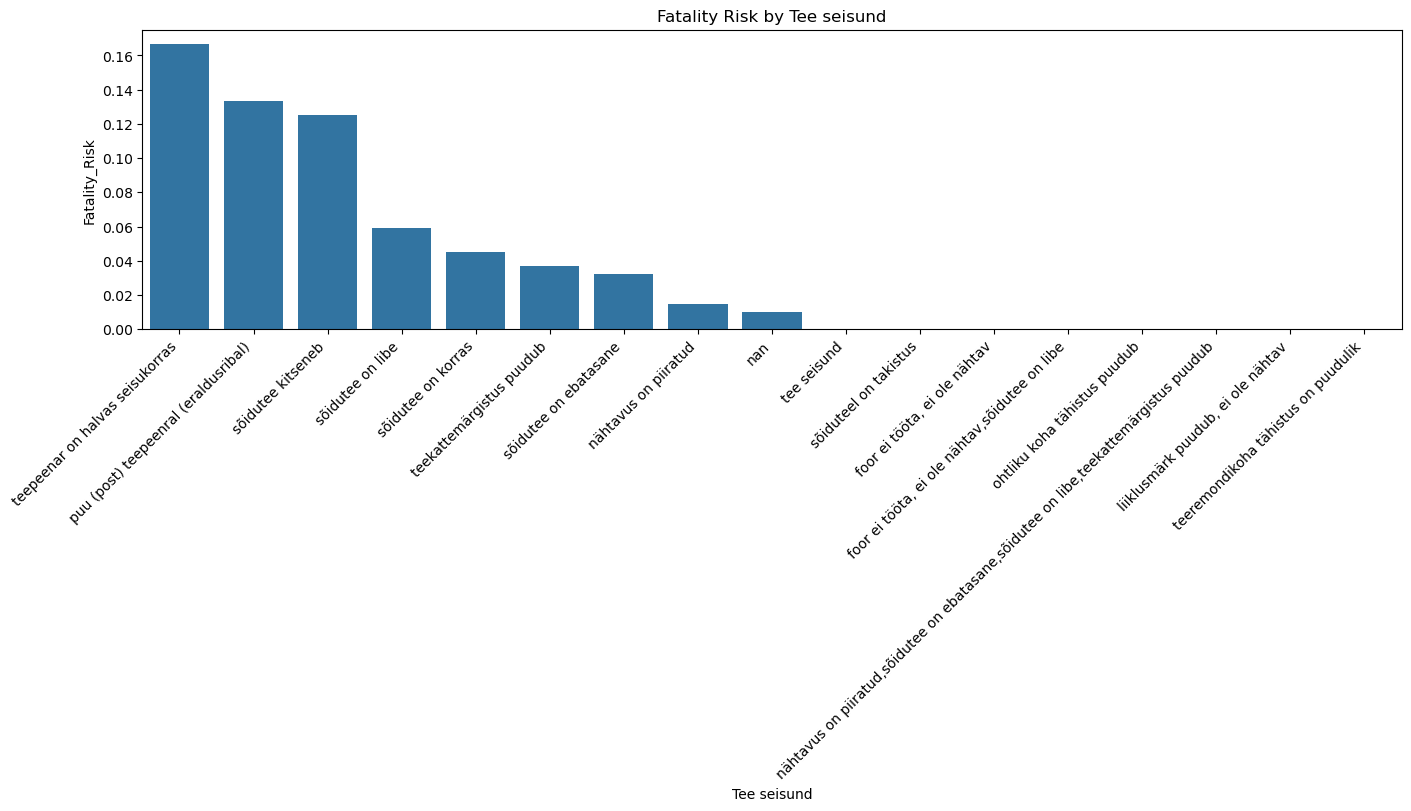

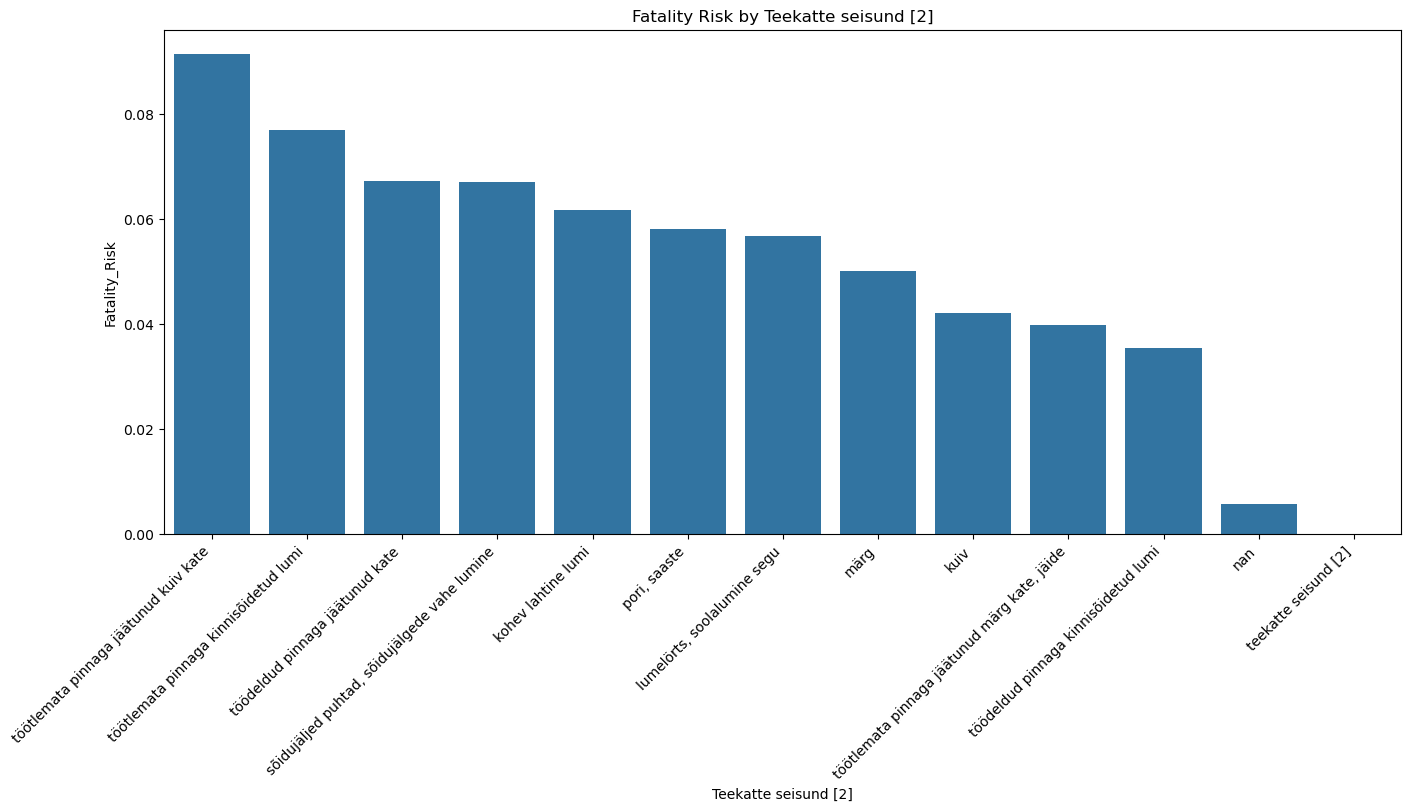

In [5]:
# define conditions to analyze
conditions = ['Ilmastik [1]', 'Tee tüüp [1]', 'Valgustus [1]', 'Tee seisund', 'Teekatte seisund [2]']

# calculate fatality risk for each condition
condition_risks = []

for condition in conditions:
    # filter out entries with missing condition data
    df_condition = df[df[condition].notna()]
    
    # create a crosstab of accidents and fatalities
    crosstab = pd.crosstab(df_condition[condition], df_condition['Fatal_Accident'])
    crosstab['Fatality_Risk'] = crosstab[1] / (crosstab[0] + crosstab[1])
    crosstab = crosstab.reset_index()
    crosstab['Condition'] = condition

    condition_risks.append(crosstab)

# combine all condition risks
condition_risks_df = pd.concat(condition_risks)

# visualize fatality risk by condition
for condition in conditions:
    subset = condition_risks_df[condition_risks_df['Condition'] == condition]
    subset = subset.sort_values('Fatality_Risk', ascending=False)
    
    plt.figure(figsize=(14, 8), constrained_layout=True)  # Larger figure with constrained layout
    sns.barplot(data=subset, x=condition, y='Fatality_Risk')
    plt.title(f'Fatality Risk by {condition}')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better fit
    plt.show()


Task 2c: Time-Based Analysis
We'll examine how accidents and fatalities vary by time of day, day of the week, and month.

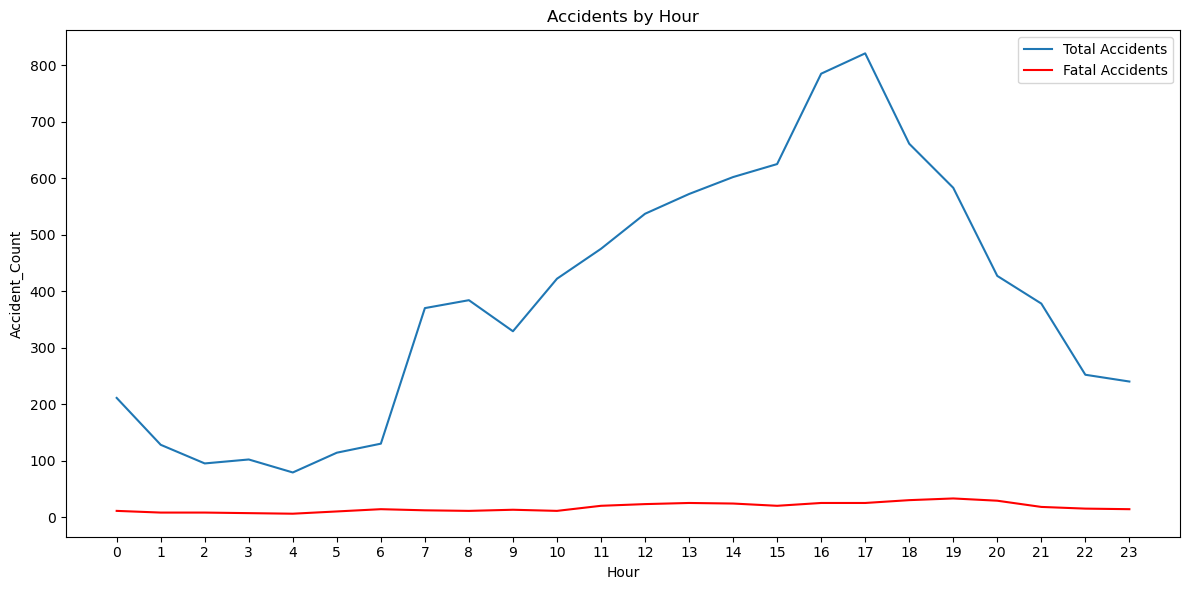

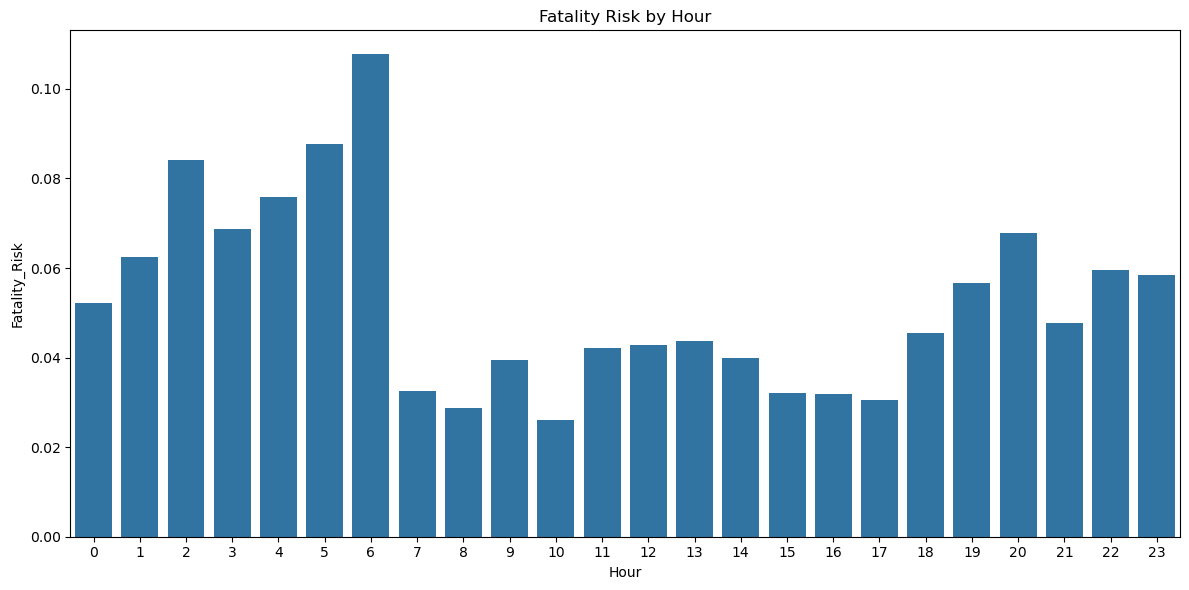

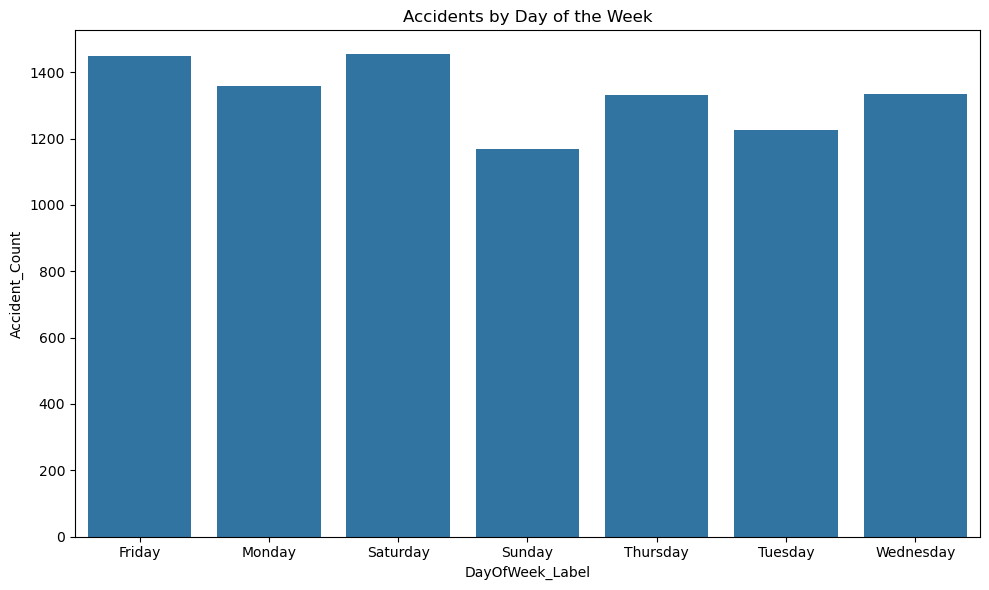

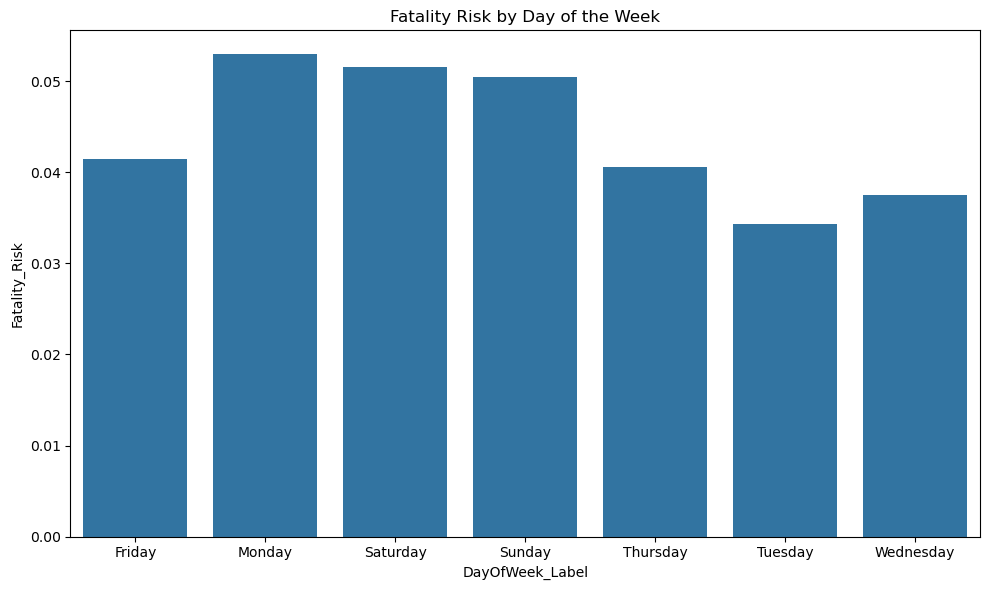

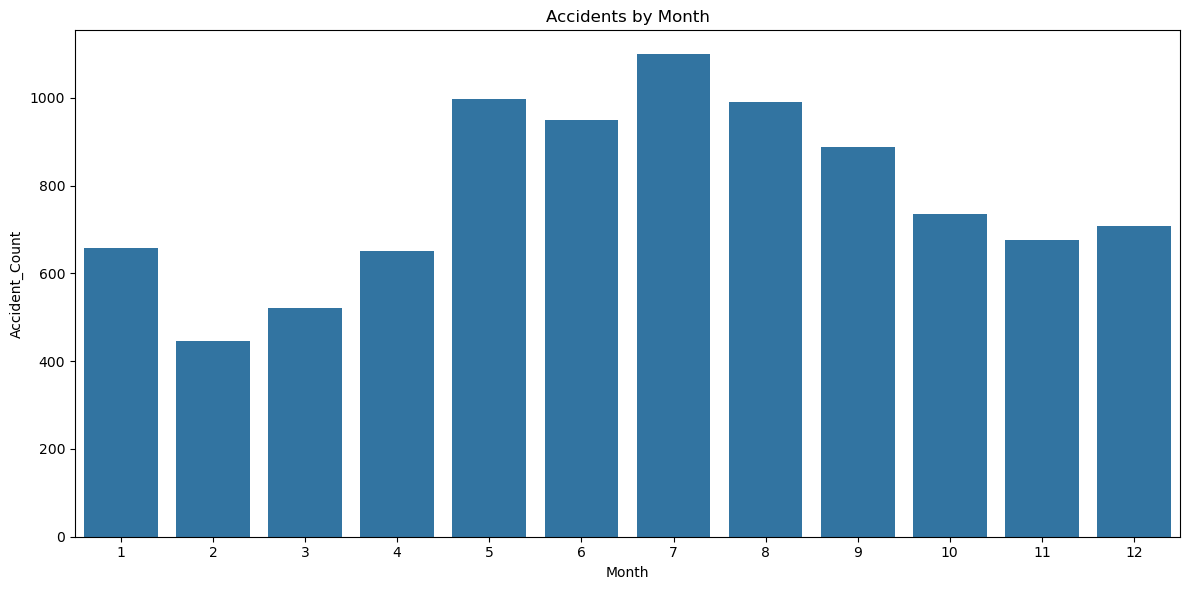

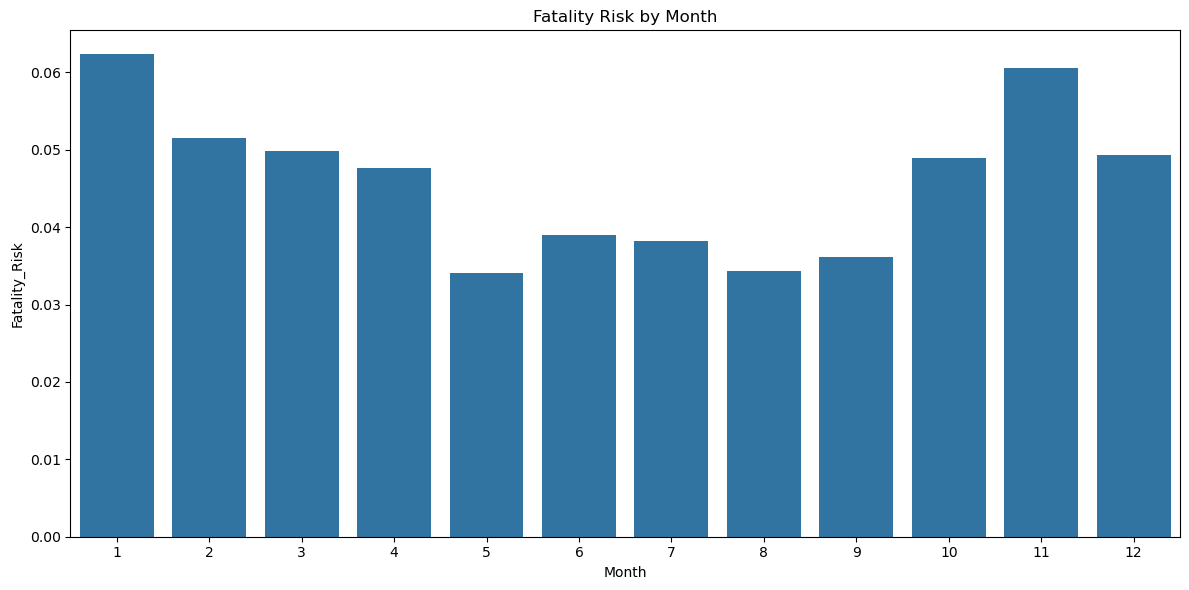

In [7]:
# filter out entries with invalid month
df_valid_time = df[df['Month'] != -1]

# accidents by hour
hourly_accidents = df_valid_time[df_valid_time['Hour'] != -1].groupby('Hour')['Juhtumi nr'].count().reset_index(name='Accident_Count')
hourly_fatal_accidents = df_valid_time[(df_valid_time['Fatal_Accident'] == 1) & (df_valid_time['Hour'] != -1)].groupby('Hour')['Juhtumi nr'].count().reset_index(name='Fatal_Accident_Count')

hourly_data = pd.merge(hourly_accidents, hourly_fatal_accidents, on='Hour', how='left').fillna(0)
hourly_data['Fatality_Risk'] = hourly_data['Fatal_Accident_Count'] / hourly_data['Accident_Count']

# plot accidents by hour
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_data, x='Hour', y='Accident_Count', label='Total Accidents')
sns.lineplot(data=hourly_data, x='Hour', y='Fatal_Accident_Count', label='Fatal Accidents', color='red')
plt.title('Accidents by Hour')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# plot fatality risk by hour
plt.figure(figsize=(12, 6))
sns.barplot(data=hourly_data, x='Hour', y='Fatality_Risk')
plt.title('Fatality Risk by Hour')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# accidents by day of the week
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_valid_time = df_valid_time[df_valid_time['DayOfWeek'] != -1]
df_valid_time['DayOfWeek_Label'] = df_valid_time['DayOfWeek'].apply(lambda x: day_labels[x] if x >= 0 and x < 7 else 'Unknown')

day_accidents = df_valid_time.groupby('DayOfWeek_Label')['Juhtumi nr'].count().reset_index(name='Accident_Count')
day_fatal_accidents = df_valid_time[df_valid_time['Fatal_Accident'] == 1].groupby('DayOfWeek_Label')['Juhtumi nr'].count().reset_index(name='Fatal_Accident_Count')

day_data = pd.merge(day_accidents, day_fatal_accidents, on='DayOfWeek_Label', how='left').fillna(0)
day_data['Fatality_Risk'] = day_data['Fatal_Accident_Count'] / day_data['Accident_Count']

# plot accidents by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(data=day_data, x='DayOfWeek_Label', y='Accident_Count')
plt.title('Accidents by Day of the Week')
plt.tight_layout()
plt.show()

# plot fatality risk by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(data=day_data, x='DayOfWeek_Label', y='Fatality_Risk')
plt.title('Fatality Risk by Day of the Week')
plt.tight_layout()
plt.show()

# accidents by month
monthly_accidents = df_valid_time.groupby('Month')['Juhtumi nr'].count().reset_index(name='Accident_Count')
monthly_fatal_accidents = df_valid_time[df_valid_time['Fatal_Accident'] == 1].groupby('Month')['Juhtumi nr'].count().reset_index(name='Fatal_Accident_Count')

monthly_data = pd.merge(monthly_accidents, monthly_fatal_accidents, on='Month', how='left').fillna(0)
monthly_data['Fatality_Risk'] = monthly_data['Fatal_Accident_Count'] / monthly_data['Accident_Count']

# exclude Month == -1 (already done above)

# plot accidents by month
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_data, x='Month', y='Accident_Count')
plt.title('Accidents by Month')
plt.tight_layout()
plt.show()

# plot fatality risk by month
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_data, x='Month', y='Fatality_Risk')
plt.title('Fatality Risk by Month')
plt.tight_layout()
plt.show()


## Task 2d: Driver Profiling
#### We'll analyze driver-related factors to identify profiles associated with higher accident involvement.

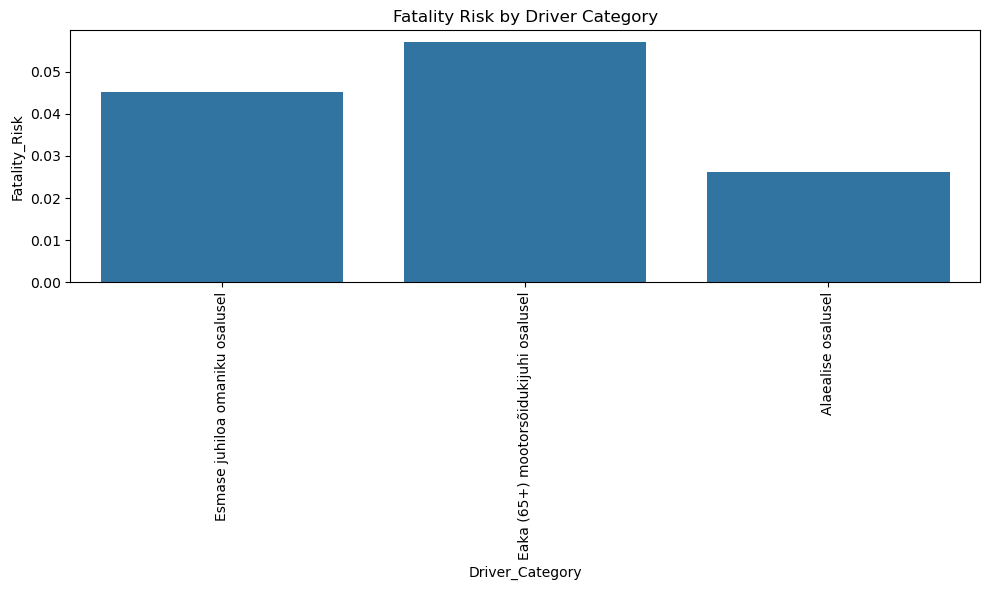

In [9]:
# driver-related columns
driver_columns = [
    'Esmase juhiloa omaniku osalusel', 
    'Eaka (65+) mootorsõidukijuhi osalusel', 
    'Alaealise osalusel'
]

# ensure driver columns are numeric
for col in driver_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# calculate fatality risk for each driver category
driver_risks = []

for col in driver_columns:
    total_accidents = df[col].sum()
    fatal_accidents = df[df['Fatal_Accident'] == 1][col].sum()
    fatality_risk = fatal_accidents / total_accidents if total_accidents > 0 else 0
    driver_risks.append({
        'Driver_Category': col,
        'Total_Accidents': total_accidents,
        'Fatal_Accidents': fatal_accidents,
        'Fatality_Risk': fatality_risk
    })

driver_risks_df = pd.DataFrame(driver_risks)

# visualize fatality risk by driver category
plt.figure(figsize=(10, 6))
sns.barplot(data=driver_risks_df, x='Driver_Category', y='Fatality_Risk')
plt.title('Fatality Risk by Driver Category')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Task 2e: High-Risk Streets and Spatial Analysis
In this section, we'll identify the streets with the highest number of accidents and fatalities.

# TODO We'll then visualize these locations using GPS coordinates and create heatmaps for Estonia, Tallinn, and Tartu.

Top 10 Streets with Highest Number of Accidents



In [12]:
# Ensure 'Tänav (PPA)' is standardized
df['Tänav (PPA)'] = df['Tänav (PPA)'].astype(str).str.strip().str.lower()

# Count accidents by street
accidents_by_street = df['Tänav (PPA)'].value_counts().reset_index()
accidents_by_street.columns = ['Street', 'Accident_Count']

# Get top 10 streets
top10_accident_streets = accidents_by_street.iloc[1:11]
print("Top 10 Streets with Highest Number of Accidents:")
print(top10_accident_streets)


Top 10 Streets with Highest Number of Accidents:
                              Street  Accident_Count
1   tallinn - tartu - võru - luhamaa             401
2                    tallinn - narva             372
3                          pärnu mnt             359
4                          narva mnt             316
5                       paldiski mnt             254
6             tallinn - pärnu - ikla             251
7                        sõpruse pst             221
8                       tallinna mnt             180
9                          tartu mnt             179
10             jõhvi - tartu - valga             157


Top 10 Streets with Highest Number of Fatalities



In [14]:
# Filter for fatal accidents
fatal_df = df[df['Fatal_Accident'] == 1]

# Count fatal accidents by street
fatalities_by_street = fatal_df['Tänav (PPA)'].value_counts().reset_index()
fatalities_by_street.columns = ['Street', 'Fatal_Accident_Count']

# Get top 10 streets
top10_fatal_streets = fatalities_by_street.iloc[1:11]
print("\nTop 10 Streets with Highest Number of Fatalities:")
print(top10_fatal_streets)



Top 10 Streets with Highest Number of Fatalities:
                              Street  Fatal_Accident_Count
1                    tallinn - narva                    46
2   tallinn - tartu - võru - luhamaa                    37
3             tallinn - pärnu - ikla                    37
4              jõhvi - tartu - valga                    22
5           pärnu - rakvere - sõmeru                    14
6                          narva mnt                     9
7                 tallinn - paldiski                     8
8   tartu - viljandi - kilingi-nõmme                     7
9       ääsmäe - haapsalu - rohuküla                     7
10                        laagna tee                     7


In [15]:
fatal_df.head()

,Juhtumi nr,Toimumisaeg,Isikuid,Hukkunuid,Vigastatuid,Sõidukeid,Aadress (PPA),Maja nr (PPA),Tänav (PPA),Ristuv tänav (PPA),Maakond (PPA),Omavalitsus (PPA),Asustus (PPA),Asula,Liiklusõnnetuse liik [1],Liiklusõnnetuse liik [3],Kergliikurijuhi osalusel,Jalakäija osalusel,Kaassõitja osalusel,Maastikusõiduki juhi osalusel,Eaka (65+) mootorsõidukijuhi osalusel,Bussijuhi osalusel,Veoautojuhi osalusel,Ühissõidukijuhi osalusel,Sõiduautojuhi osalusel,Mootorratturi osalusel,Mopeedijuhi osalusel,Jalgratturi osalusel,Alaealise osalusel,Turvavarustust mitte kasutanud isiku osalusel,Esmase juhiloa omaniku osalusel,Mootorsõidukijuhi osalusel,Tüüpskeemi nr,Tüüpskeem [2],Tee tüüp [1],Tee tüüp [2],Tee element [1],Tee element [2],Tee objekt [2],Kurvilisus,Tee tasasus,Tee seisund,Teekate,Teekatte seisund [2],Sõiduradade arv,Lubatud sõidukiirus (PPA),Tee nr (PPA),Tee km (PPA),Ilmastik [1],Valgustus [1],Valgustus [2],GPS X,GPS Y,Time_Present,Parsed_Date,Year,Month,DayOfWeek,Hour,Fatal_Accident,Injury_Accident
0,2300150007185,20.11.2015 05:31,2,1,0,1,Harju maakond Tallinn Lasnamäe linnaosa Peter...,NaN,peterburi tee,Pae tn,harju maakond,Tallinn,Lasnamäe linnaosa,JAH,Jalakäijaõnnetus,Kokkupõrge jalakäijaga,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,103,Sõiduki konflikt teelõiku vasakult poolt ületa...,kov tee/tänav,Tänav,NaN,NaN,Fooriga reguleeritud ristmik,NaN,Tasane tee,sõidutee on korras,Püsikate,märg,0,50,NaN,NaN,vihmasadu,pimeda aeg,Pimeda ajal valgustus põleb,6587834,545426,True,2015-11-20 05:31:00,2015,11,4,5,1,0
1,2300150007535,9/12/15,3,1,0,2,Harju maakond Tallinn Põhja-Tallinna linnaosa...,60,sõle tn,NaN,harju maakond,Tallinn,Põhja-Tallinna linnaosa,JAH,Jalakäijaõnnetus,Kokkupõrge jalakäijaga,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,198,Muu konflikt sõiduki ja jalakäija vahel (nt. k...,kov tee/tänav,Tänav,Ristmik,†-kujuline ristmik,Fooriga reguleeritud ristmik,Sirge tee,Tasane tee,sõidutee on korras,Püsikate,märg,0,50,NaN,NaN,pilvised olud,valge aeg,Valge aeg,6590467,539630,False,NaT,-1,-1,-1,-1,1,0
2,2300160007343,26.12.2016 00:30,1,1,0,1,Harju maakond Saku vald,NaN,tallinn - saku - laagri,NaN,harju maakond,Saku vald,NaN,EI,Ühesõidukiõnnetus,Sõiduki teelt väljasõit,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,203,Sõiduk kaotab teelõigul või ristmikul juhitavu...,riigitee,Kõrvalmaantee,Erielemendita teelõik,Erielemendita teelõik,Rajatis puudub,Sirge tee,Tasane tee,sõidutee on korras,Püsikate,kuiv,2,90,11340,8,pilvised olud,pimeda aeg,Pimeda ajal valgustus puudub,6576196,539214,True,2016-12-26 00:30:00,2016,12,0,0,1,0
3,2300200000698,27.01.2020 20:04,2,1,0,1,Harju maakond Tallinn Lasnamäe linnaosa Narva...,NaN,narva mnt,J. Smuuli tee,harju maakond,Tallinn,Lasnamäe linnaosa,JAH,Jalakäijaõnnetus,Kokkupõrge jalakäijaga,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,108,Otse sõitva ja ristmikult lahkuva sõiduki konf...,kov tee/tänav,Tänav,Ristmik,†-kujuline ristmik,Fooriga reguleeritud ristmik,Sirge tee,Tasane tee,sõidutee on korras,Püsikate,märg,0,50,NaN,NaN,vihmasadu,pimeda aeg,Pimeda ajal valgustus põleb,6590122,546479,True,2020-01-27 20:04:00,2020,1,0,20,1,0
4,2300200008312,20.06.2020 19:09,2,1,0,2,Harju maakond Tallinn Pirita linnaosa Randver...,NaN,randvere tee,Pojengi tee,harju maakond,Tallinn,Pirita linnaosa,JAH,Kokkupõrge,Kokkupõrge sõidukiga küljelt,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,501,Ristmiku peateel otse sõitva sõiduki konflikt ...,kov tee/tänav,Tänav,Ristmik,†-kujuline ristmik,Reguleerimata ristmik – liiklusmärkideta,Sirge tee,Tasane tee,sõidutee on korras,Püsikate,kuiv,0,50,NaN,NaN,selged olud,valge aeg,Valge aeg,6594972,549609,True,2020-06-20 19:09:00,2020,6,5,19,1,0


In [16]:
# Ensure columns are numeric
fatal_df_gps = fatal_df[["GPS X", "GPS Y"]].copy()

fatal_df_gps["GPS X"] = pd.to_numeric(fatal_df["GPS X"], errors="coerce")
fatal_df_gps["GPS Y"] = pd.to_numeric(fatal_df["GPS Y"], errors="coerce")


# Drop rows with missing or invalid coordinates
fatal_df_gps = fatal_df_gps.dropna(subset=["GPS X", "GPS Y"])

# Check if dataset still contains valid rows
if fatal_df_gps.empty:
    raise ValueError("No valid GPS data available after cleaning.")

fatal_df_gps.head()

,GPS X,GPS Y
0,6587834.0,545426.0
1,6590467.0,539630.0
2,6576196.0,539214.0
3,6590122.0,546479.0
4,6594972.0,549609.0


In [17]:
from pyproj import Transformer

# Initialize the transformer: L-EST97 (EPSG:3301) to WGS84
transformer = Transformer.from_crs("epsg:3301", "epsg:4326", always_xy=True)

# Apply the transformation with swapped input (Y, X) for EPSG:3301
def convert_to_latlon(row):
    lon, lat = transformer.transform(row["GPS Y"], row["GPS X"])  # Swap the axes
    return pd.Series([lon, lat], index=["GPS X", "GPS Y"])

# Transform the coordinates
fatal_df_gps = fatal_df.apply(convert_to_latlon, axis=1)

# Round the results to 6 decimal places for clarity
fatal_df_gps["GPS X"] = fatal_df_gps["GPS X"].round(6)
fatal_df_gps["GPS Y"] = fatal_df_gps["GPS Y"].round(6)

# Check the converted data
print(fatal_df_gps.head())


       GPS X      GPS Y
0  24.800265  59.425932
1  24.698649  59.450146
2  24.688732  59.322089
3  24.819306  59.446354
4  24.875590  59.489530


Visualizing Streets on a Map
We'll use the folium library to visualize the top accident locations on a map.

In [19]:
import folium
from folium.plugins import HeatMap

# Drop rows with NaN values, if any
fatal_df_gps = fatal_df_gps.dropna(subset=["GPS X", "GPS Y"])

# Center the map based on the mean coordinates
map_center_x = fatal_df_gps["GPS X"].mean()
map_center_y = fatal_df_gps["GPS Y"].mean()

# Create a Folium map
m = folium.Map(location=[map_center_y, map_center_x], zoom_start=7)

# Prepare data for the heatmap
heat_data = fatal_df_gps[["GPS Y", "GPS X"]].values.tolist()

# Add the HeatMap layer
HeatMap(heat_data).add_to(m)

# Save and display the map
m.save("heatmap_estonia.html")

m

# Task 3: Data Preparation
In this section, we'll prepare the data for modeling. This includes handling missing values, encoding categorical variables, feature engineering, and splitting the data into training and testing sets

## Data Cleaning and Handling Missing Values
We'll first check for missing values and decide on strategies to handle them.

In [21]:
# Improved date parsing function
def parse_date(date_str):
    date_formats = [
        '%d.%m.%Y %H:%M',
        '%d.%m.%Y',
        '%d/%m/%Y %H:%M',
        '%d/%m/%Y',
        '%d.%m.%y %H:%M',
        '%d.%m.%y',
        '%d/%m/%y %H:%M',
        '%d/%m/%y',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d',
    ]
    for fmt in date_formats:
        try:
            return pd.to_datetime(date_str, format=fmt, dayfirst=True)
        except (ValueError, TypeError):
            continue
    return pd.NaT

# Apply the improved date parser
df['Parsed_Date'] = df['Toimumisaeg'].apply(parse_date)

# Drop rows with missing 'Parsed_Date'
df = df[df['Parsed_Date'].notna()].copy()

df.drop(columns=['Aadress (PPA)'], inplace=True)


## 3.1 Handling Missing Values

We'll clean numerical columns, handle missing numerical values, and standardize categorical columns. Additionally, we'll drop columns with excessive missing data.


In [23]:
# Clean numerical columns
numerical_columns = [
    'Isikuid', 'Hukkunuid', 'Vigastatuid', 'Sõidukeid', 
    'Sõiduradade arv', 'Lubatud sõidukiirus (PPA)'
]
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing numerical values
df['Sõiduradade arv'] = df['Sõiduradade arv'].fillna(df['Sõiduradade arv'].median())
df['Lubatud sõidukiirus (PPA)'] = df['Lubatud sõidukiirus (PPA)'].fillna(df['Lubatud sõidukiirus (PPA)'].median())

# For count-based columns, fill missing with 0
count_columns = ['Isikuid', 'Hukkunuid', 'Vigastatuid', 'Sõidukeid']
for col in count_columns:
    df[col] = df[col].fillna(0)

# Convert to integers
df[numerical_columns] = df[numerical_columns].astype(int)

# Standardize categorical variables
categorical_columns = [
    'Maakond (PPA)', 'Ilmastik [1]', 'Tee tüüp [1]', 
    'Valgustus [1]', 'Tee seisund', 'Teekatte seisund [2]'
]
for col in categorical_columns:
    df[col] = df[col].astype(str).str.strip().str.lower()
    df[col] = df[col].fillna('puudub')

# Drop columns with excessive missing data
df.drop(columns=['Asula',"Omavalitsus (PPA)",'Maja nr (PPA)', 'Ristuv tänav (PPA)', 'Asustus (PPA)', 'Tee nr (PPA)', 'Tee km (PPA)', "Tänav (PPA)"], inplace=True)


## 3.2 Encoding Categorical Variables

We'll encode binary categorical variables using label encoding and other categorical variables with one-hot encoding.


In [25]:
# Label encoding for binary categorical variables
binary_columns = ['Jalakäija osalusel', 'Kaassõitja osalusel', 'Sõiduautojuhi osalusel','Esmase juhiloa omaniku osalusel', 'Eaka (65+) mootorsõidukijuhi osalusel', 'Alaealise osalusel']
for col in binary_columns:
    df[col] = df[col].map({'JAH': 1, 'jah': 1, 'EI': 0, 'ei': 0}).fillna(0).astype(int)

# One-hot encoding for other categorical variables
categorical_cols = [
    'Maakond (PPA)', 'Ilmastik [1]', 'Tee tüüp [1]', 'Valgustus [1]', 
    'Tee seisund', 'Teekatte seisund [2]'
]
df_encoded = pd.get_dummies(df, columns=categorical_cols)


## 3.3 Feature Engineering

We'll create a new feature for accident severity and time-based features.


In [27]:

# Create time-based features
df_encoded['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df_encoded['Is_Night'] = df['Hour'].apply(lambda x: 1 if (x >= 22 or x <= 5) else 0)


## 3.4 Splitting the Data

We'll split the data into training and testing sets, ensuring no target leakage by removing 'Hukkunuid' and 'Vigastatuid' columns.


In [29]:
from sklearn.model_selection import train_test_split


df_encoded.drop(columns=['Injury_Accident'], inplace=True, errors='ignore')

# Define the features and target variable
features = df_encoded.drop(['Juhtumi nr', 'Toimumisaeg', 'Parsed_Date', 'Time_Present', 'Fatal_Accident', 'Hukkunuid', 'Vigastatuid'], axis=1)
target = df_encoded['Fatal_Accident']

# Split the data<
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)


# Task 4: Modeling

In this task, we'll train models, evaluate them, and compare their performance.


In [31]:
# Handling categorical columns for models
categorical_cols_to_encode = [
    'Liiklusõnnetuse liik [1]', 'Liiklusõnnetuse liik [3]', 'Tüüpskeemi nr', 
    'Tüüpskeem [2]', 'Tee tüüp [2]', 'Tee element [1]', 
    'Tee element [2]', 'Tee objekt [2]', 'Kurvilisus', 
    'Tee tasasus', 'Teekate', 'Valgustus [2]'
]

# Combine X_train and X_test for consistent encoding
X_combined = pd.concat([X_train, X_test], axis=0)

# Perform one-hot encoding
X_combined_encoded = pd.get_dummies(X_combined, columns=categorical_cols_to_encode)

# Split back into X_train and X_test
X_train_encoded = X_combined_encoded.iloc[:len(X_train), :].reset_index(drop=True)
X_test_encoded = X_combined_encoded.iloc[len(X_train):, :].reset_index(drop=True)

# Update X_train and X_test
X_train = X_train_encoded
X_test = X_test_encoded


## 4.1 Handling Class Imbalance

We'll use SMOTE to oversample the minority class in the training data.


In [33]:
from imblearn.over_sampling import SMOTE
numeric_cols_to_convert = [
    'Kergliikurijuhi osalusel',
    'Maastikusõiduki juhi osalusel',
    'Bussijuhi osalusel',
    'Veoautojuhi osalusel',
    'Ühissõidukijuhi osalusel',
    'Mootorratturi osalusel',
    'Mopeedijuhi osalusel',
    'Jalgratturi osalusel',
    'Turvavarustust mitte kasutanud isiku osalusel',
    'Mootorsõidukijuhi osalusel',
    'GPS X',
    'GPS Y'
]

# Copy the original ones
X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()

# Convert to numeric, handling errors
for col in numeric_cols_to_convert:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
# Fill NaN values with appropriate values, e.g., 0
for col in numeric_cols_to_convert:
    X_train[col] = X_train[col].fillna(0)
    X_test[col] = X_test[col].fillna(0)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


## 4.2 Model Development

We'll train and evaluate Logistic Regression, Random Forest, and Gradient Boosting models.


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Logistic Regression
lr_model = LogisticRegression(max_iter=2000, random_state=42)
lr_model.fit(X_train_res, y_train_res)
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluate Logistic Regression
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_lr)}")


Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      3000
           1       0.10      0.28      0.15       142

    accuracy                           0.86      3142
   macro avg       0.53      0.58      0.54      3142
weighted avg       0.92      0.86      0.89      3142

ROC AUC Score: 0.6927253521126762


C:\Users\Mingiii Klu\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=200,
    min_samples_split=2,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    criterion="entropy",
    class_weight='balanced',
    random_state=20
)

# Lets use the data before SMOTE, as it is better for random forests
rf_model.fit(X_train_original, y_train_original)
y_pred_rf = rf_model.predict(X_test_original)
y_proba_rf = rf_model.predict_proba(X_test_original)[:, 1]

# Evaluate Random Forest
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_rf)}")

Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3000
           1       0.24      0.31      0.27       142

    accuracy                           0.93      3142
   macro avg       0.60      0.63      0.62      3142
weighted avg       0.93      0.93      0.93      3142

ROC AUC Score: 0.8205868544600939


In [37]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_res, y_train_res)
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluate Gradient Boosting
print("Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_gb)}")


Gradient Boosting:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3000
           1       0.29      0.06      0.10       142

    accuracy                           0.95      3142
   macro avg       0.62      0.53      0.54      3142
weighted avg       0.93      0.95      0.94      3142

ROC AUC Score: 0.80056338028169


In [38]:
from catboost import CatBoostClassifier

# CatBoost model
catboost_model = CatBoostClassifier(
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=200 
)

# Fit the model
cb_model = catboost_model
cb_model.fit(X_train_res, y_train_res)
y_pred_cb = cb_model.predict(X_test)
y_proba_cb = cb_model.predict_proba(X_test)[:, 1]

# Evaluate CatBoost
print("CatBoost:")
print(classification_report(y_test, y_pred_cb))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_cb)}")

Learning rate set to 0.040016
0:	total: 191ms	remaining: 3m 11s
100:	total: 1.91s	remaining: 17s
200:	total: 3.44s	remaining: 13.7s
300:	total: 5s	remaining: 11.6s
400:	total: 6.53s	remaining: 9.76s
500:	total: 8.04s	remaining: 8.01s
600:	total: 9.57s	remaining: 6.36s
700:	total: 11s	remaining: 4.71s
800:	total: 12.6s	remaining: 3.12s
900:	total: 14s	remaining: 1.54s
999:	total: 15.5s	remaining: 0us
CatBoost:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3000
           1       0.60      0.08      0.15       142

    accuracy                           0.96      3142
   macro avg       0.78      0.54      0.56      3142
weighted avg       0.94      0.96      0.94      3142

ROC AUC Score: 0.7923239436619719


## 4.3 Model Comparison

We'll compare the models' performance based on ROC AUC scores.


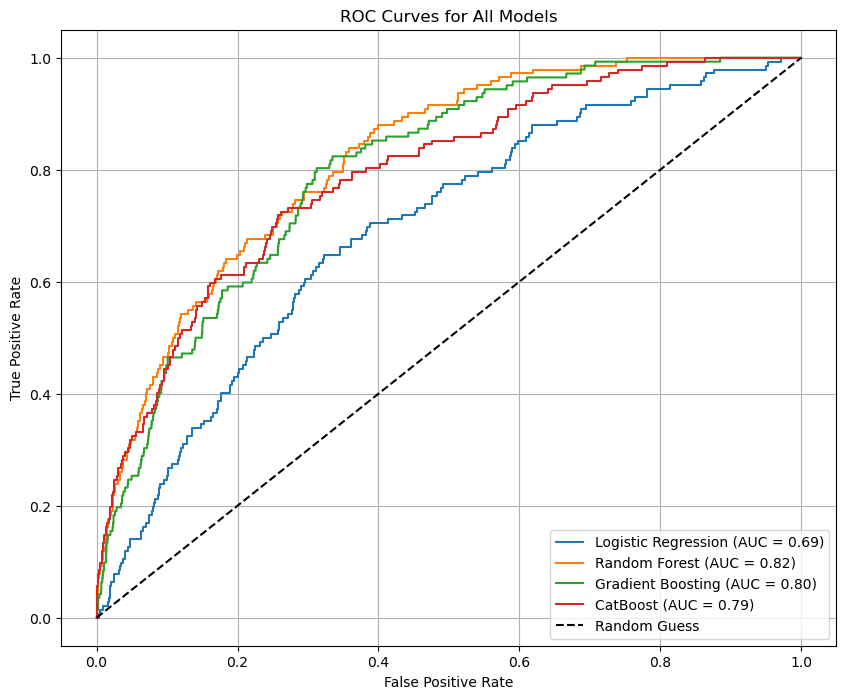

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Function to plot the ROC curve for multiple models
def plot_multiple_roc_curves(models, y_test, probabilities, labels):
    plt.figure(figsize=(10, 8))
    for model, y_proba, label in zip(models, probabilities, labels):
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Collect model probabilities and labels
probabilities = [y_proba_lr, y_proba_rf, y_proba_gb, y_proba_cb]
labels = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'CatBoost']

# Plot all ROC curves
plot_multiple_roc_curves([lr_model, rf_model, gb_model, cb_model], y_test, probabilities, labels)


## Most critical features for determing fatality in the models

In [42]:
# Get feature importance for Logistic Regression
lr_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_[0]
})
lr_feature_importance['Abs_Coefficient'] = lr_feature_importance['Coefficient'].abs()
lr_feature_importance = lr_feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

print("Top 10 Important Features for Logistic Regression:")

print(lr_feature_importance.head(10))

# Get feature importance for Random Forest
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)

print("Top 10 Important Features for Random Forest:")
print(rf_feature_importance.head(10))


# Get feature importance for Gradient Boosting
gb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
})
gb_feature_importance = gb_feature_importance.sort_values(by='Importance', ascending=False)

print("Top 10 Important Features for Gradient Boosting:")
print(gb_feature_importance.head(10))

# Get feature importance for CatBoost
cb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cb_model.feature_importances_
})
cb_feature_importance = cb_feature_importance.sort_values(by='Importance', ascending=False)

print("Top 10 Important Features for CatBoost:")
print(cb_feature_importance.head(10))



Top 10 Important Features for Logistic Regression:
                                               Feature  Coefficient  \
88                                            Is_Night    -1.432179   
55                               Tee tüüp [1]_riigitee     1.199447   
57                            Valgustus [1]_pimeda aeg     1.164516   
101  Liiklusõnnetuse liik [3]_Kokkupõrge vastutulev...     1.158532   
90                 Liiklusõnnetuse liik [1]_Kokkupõrge     1.070610   
193  Tüüpskeem [2]_Konflikt vastassuundadest otse s...     1.042187   
165                                  Tüüpskeemi nr_601     1.042187   
270                           Tee tüüp [2]_Põhimaantee     1.040741   
89           Liiklusõnnetuse liik [1]_Jalakäijaõnnetus     0.950192   
96     Liiklusõnnetuse liik [3]_Kokkupõrge jalakäijaga     0.950192   

     Abs_Coefficient  
88          1.432179  
55          1.199447  
57          1.164516  
101         1.158532  
90          1.070610  
193         1.042187  
165   

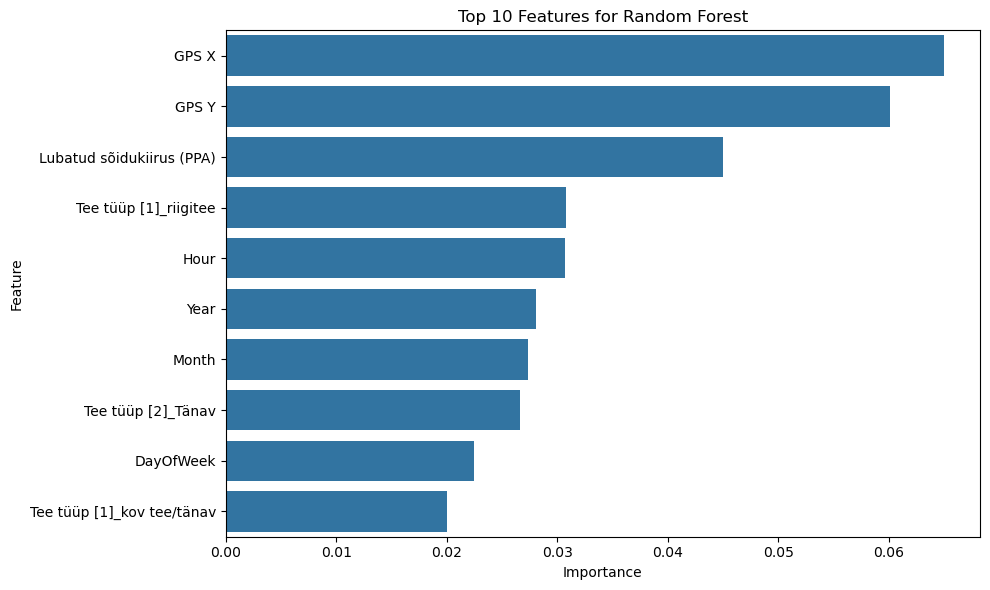

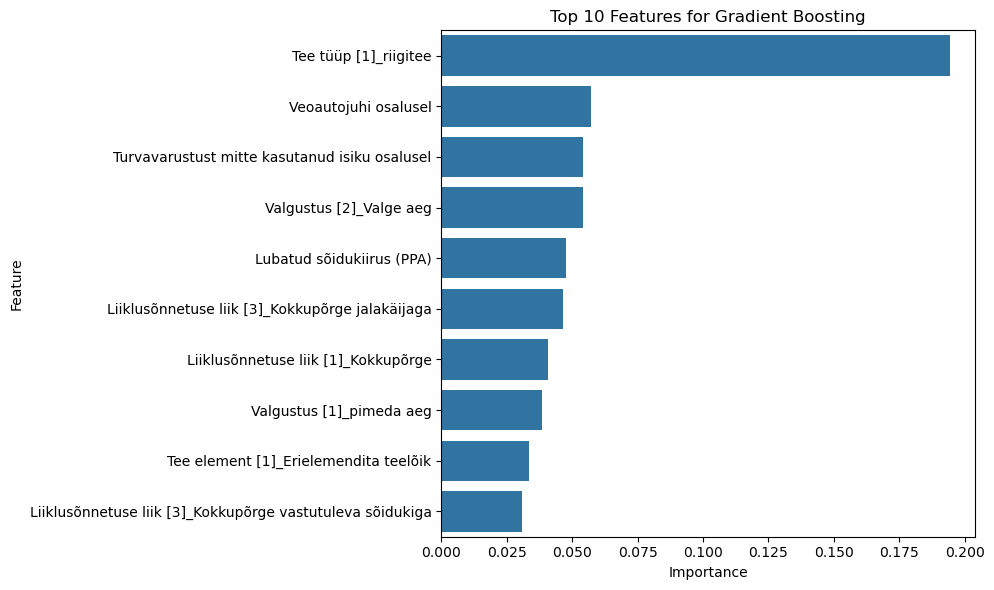

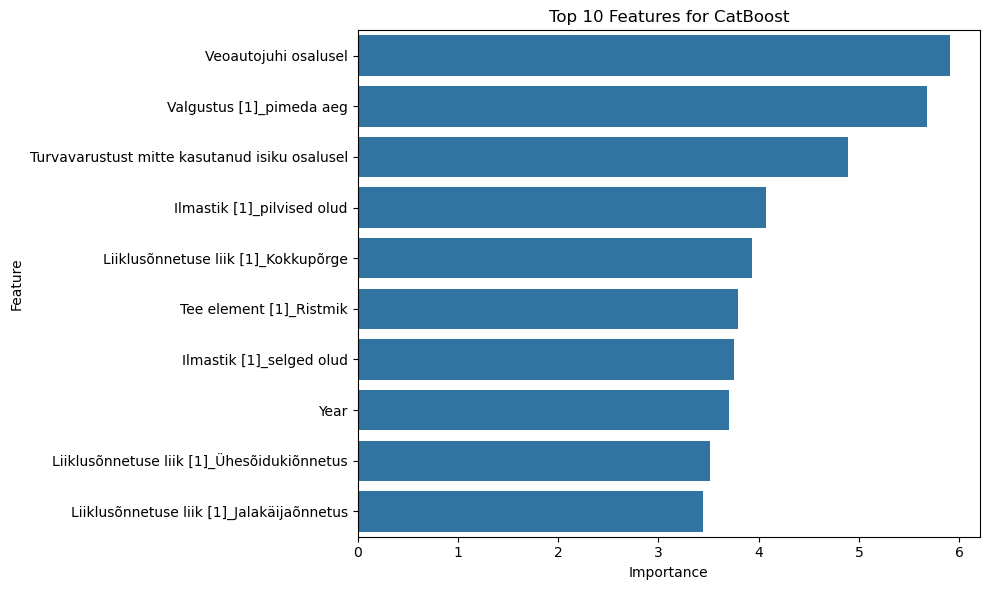

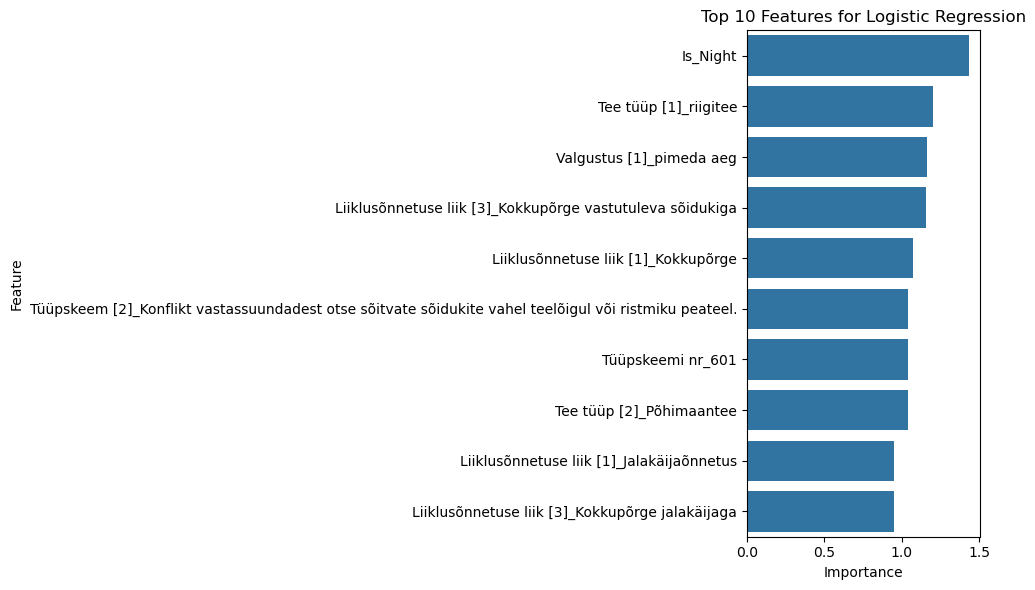

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting function for feature importance
def plot_feature_importance(df, model_name, top_n=10):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df.head(top_n), x='Importance', y='Feature')
    plt.title(f"Top {top_n} Features for {model_name}")
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Plot for Random Forest
plot_feature_importance(rf_feature_importance, "Random Forest")

# Plot for Gradient Boosting
plot_feature_importance(gb_feature_importance, "Gradient Boosting")

# Plot for CatBoost
plot_feature_importance(cb_feature_importance, "CatBoost")

# For Logistic Regression
plot_feature_importance(lr_feature_importance.rename(columns={'Abs_Coefficient': 'Importance'}), "Logistic Regression")
